# Conv2D implementation of the Inner speech dataset

In [1]:
import os
import mne
import pickle
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Inner_Speech_Dataset.Python_Processing.Data_extractions import  Extract_data_from_subject
from Inner_Speech_Dataset.Python_Processing.Data_processing import  Select_time_window, Transform_for_classificator, Split_trial_in_time

np.random.seed(23)

mne.set_log_level(verbose='warning') #to avoid info at terminal
warnings.filterwarnings(action = "ignore", category = DeprecationWarning )
warnings.filterwarnings(action = "ignore", category = FutureWarning )

In [2]:
%%time
# The Storage variables with their respected names
X_train =[]
Y_train =[]
X_val = []
Y_val =[]
X_test = []
Y_test = []

### Hyperparameters
datatype = "EEG"     # Data Type
fs = 256             # Sampling rate
t_start = 1.5        # Select the useful par of each trial. Time in seconds
t_end = 3.5

# Setting parameters
root_dir = "dataset/inner-speech-recognition"             # path to the main directory of the subjects
subject_numbers = [1,2,3,4,5,6,7,8,9]                  # Number of subjects
Conditions = [["Inner"],["Inner"],["Inner"],["Inner"]]    # Paradigm of data that want to classify
Classes = [  ["Up"] ,["Down"],["Right"],["Left"]]         # The four clases of data


# Main for loop to extract the data and append it
for s_n in subject_numbers:
    X_sub, Y_sub = Extract_data_from_subject(root_dir, s_n, datatype)
    X_sub = Select_time_window(X = X_sub, t_start = t_start, t_end = t_end, fs = fs)
    X_transformed , Y_transformed =  Transform_for_classificator(X_sub, Y_sub, Classes, Conditions)
    
    ## Separating for testing set
    indices = np.arange(10, len(X_transformed), 10)
    X_tt = X_transformed[indices].copy()
    Y_tt = Y_transformed[indices].copy()
    # Removed after separating for testing set 
    X_t =  np.delete(X_transformed, indices, axis =0)
    Y_t =  np.delete(Y_transformed, indices)
    
    ## Separating for Validation set
    indices = np.arange(9, len(X_t), 9)
    X_tt_val = X_t[indices].copy()
    Y_tt_val = Y_t[indices].copy()
    # Removed after separating for testing set 
    X_t =  np.delete(X_t, indices, axis =0)
    Y_t =  np.delete(Y_t, indices)
       
    # Appending data to the main sets
    X_train.append(X_t)
    Y_train.append(Y_t)
    X_val.append(X_tt_val)
    Y_val.append(Y_tt_val)
    X_test.append(X_tt)
    Y_test.append(Y_tt)

# Vertically Concatenate all the data of one subject after another
X_train = np.concatenate(X_train, axis=0)
Y_train = np.concatenate(Y_train, axis=0)
X_val = np.concatenate(X_val, axis=0)
Y_val = np.concatenate(Y_val, axis=0)
X_test = np.concatenate(X_test, axis=0)
Y_test = np.concatenate(Y_test, axis=0)

# Suffled X_train and Y_train
indices = np.random.permutation(X_train.shape[0])
X_train = X_train[indices]
Y_train = Y_train[indices]


# Printing the shape
print("The shape of the X_train x Y_train ", X_train.shape , " x ",Y_train.shape)
print("The shape of the X_val x Y_val ", X_val.shape , " x ",Y_val.shape)
print("The shape of the X_test x Y_test: ", X_test.shape, " x ",Y_test.shape)

The shape of the X_train x Y_train  (1606, 128, 512)  x  (1606,)
The shape of the X_val x Y_val  (199, 128, 512)  x  (199,)
The shape of the X_test x Y_test:  (191, 128, 512)  x  (191,)
CPU times: total: 32.2 s
Wall time: 36.4 s


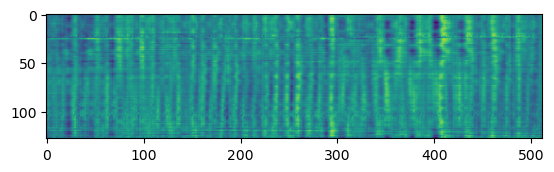

In [3]:
plt.imshow(X_train[100])

## Applying CNN

In [4]:
import torch
import torch.nn as nn

In [5]:
# Define model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(32 * 64 * 256, 4)  # num_classes is the number of output classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc(x)
        return x

model = CNN()
model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=524288, out_features=4, bias=True)
)

In [6]:
# Selecting Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print('Using device:', device)

Using device: cuda


In [12]:
# Unsqueezing and Flattening the dataset
X_train_unsq = torch.from_numpy(X_train).unsqueeze(1).float().to(device)   # Add a channel dimension and convert to float tensor
Y_train_flat = torch.from_numpy(Y_train).long().to(device)                 # Convert to long tensor

In [8]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
batch_size = 32  # Adjust the batch size as per your GPU memory capacity
accumulation_steps = 4  # Accumulate gradients over 4 batches before performing optimizer step
num_batches = len(X_train_unsq) // batch_size
num_epochs =10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    for i in range(num_batches):
        start = i * batch_size
        end = (i + 1) * batch_size
        inputs = X_train_unsq[start:end].to(device)
        targets = Y_train_flat[start:end].to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss = loss / accumulation_steps  # Divide the loss by accumulation steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training complete!")

Epoch [1/10], Loss: 7.0137
Epoch [2/10], Loss: 4.9184
Epoch [3/10], Loss: 1.7113
Epoch [4/10], Loss: 0.8572
Epoch [5/10], Loss: 1.2106
Epoch [6/10], Loss: 1.0007
Epoch [7/10], Loss: 2.2444
Epoch [8/10], Loss: 1.6583
Epoch [9/10], Loss: 2.5961
Epoch [10/10], Loss: 1.1403
Training complete!


In [10]:
## Training accuracy
# Make prediction
device = torch.device("cpu")
model.to(device)

X_val_unsq = torch.from_numpy(X_val).unsqueeze(1).float().to(device)   # Add a channel dimension and convert to float tensor
Y_val_flat = torch.from_numpy(Y_val).long().to(device)                 # Convert to long tensor               

model.eval()  # Set the model in evaluation mode
with torch.no_grad():
    outputs = model(X_train_acc.to(device))
    _, predicted = torch.max(outputs.data, 1)  # Get the predicted classes

correct = (predicted == Y_train_acc.to(device)).sum().item()
accuracy = correct / len(predicted) * 100
print(f"Accuracy on test data: {accuracy:.2f}%")

Accuracy on test data: 21.61%


## Evaluating the model

In [13]:
X_val_unsq = X_val_unsq.to(device)       # Add a channel dimension and convert to float tensor
Y_val_flat = Y_val_flat.to(device)                     # Convert to long tensor

model.eval()  # Set the model in evaluation mode
with torch.no_grad():
    outputs = model(X_val_unsq.to(device))
    _, predicted = torch.max(outputs.data, 1)  # Get the predicted classes

correct = (predicted == Y_val_flat.to(device)).sum().item()
accuracy = correct / len(predicted) * 100
print(f"Accuracy on test data: {accuracy:.2f}%")

Accuracy on test data: 25.13%


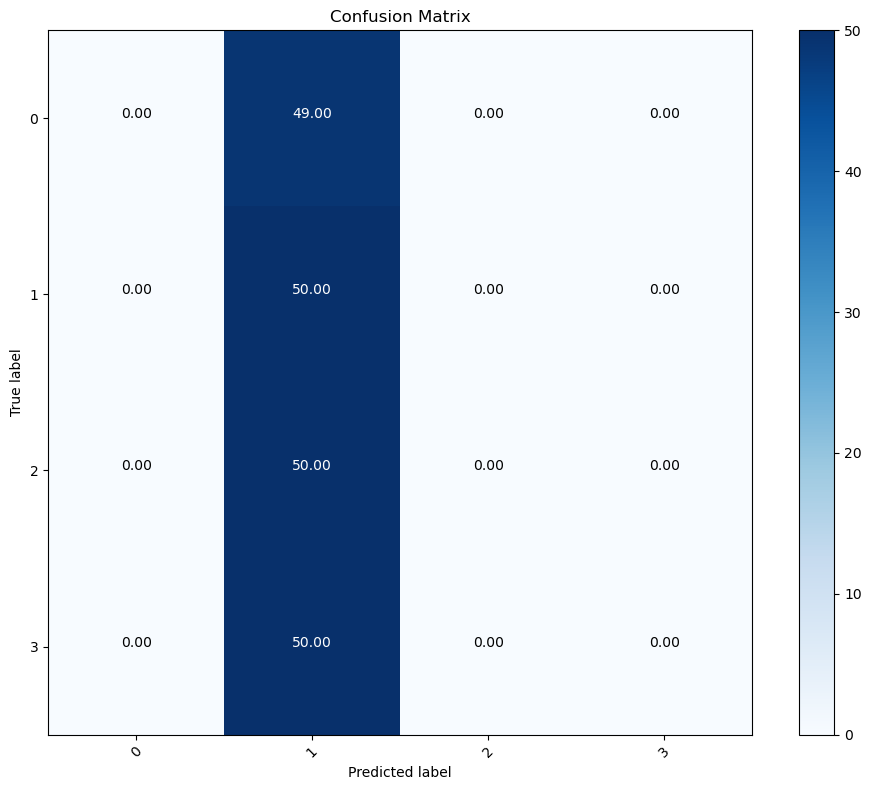

In [14]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_val_flat.numpy(), predicted.numpy())
classes = [0,1,2,3]

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()